In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint

# Load dataset
dataset = np.loadtxt('dataset-GS1-GS10.txt').T

# Discard extreme values and nan values
# Find rows with any NaN values
rows_with_nan = np.isnan(dataset).any(axis=1)
# Delete rows with NaN values
data = dataset[~rows_with_nan, :]
Tw = 0.6756;
# Minus d for roughness
data[:,0] = data[:,0]-data[:,23];
data[18460:, 20] += 59  # Adjusting for 0-based indexing in Python

# Filter data, matching location
idy = (data[:, 0] > 0.02) & (data[:, 0] < 0.15)
data = data[idy, :]
idT = (data[:, 2] - Tw > 0)
data = data[idT, :]
condition = (data[:, 21] == 4) & (data[:, 22] == 4000)

data = data[~condition]
print('data size: ',data.shape)
# Reform input and output
input_data = np.column_stack((data[:, 0], data[:, 1], data[:, 3], data[:, 2] , np.full_like(data[:,1], Tw), data[:, 4],
                              data[:, 7], data[:, 6], data[:, 11], data[:, 12], data[:, 15]))

output_tauw = data[:, 18] * data[:, 0] / data[:, 4] / data[:, 1]
output_qw = data[:, 19] * data[:, 0] / (data[:, 2] - Tw) / data[:, 7]
index = data[:, 20]

data size:  (2692, 24)


In [2]:
import numpy as np

# Define D_in matrix
D_in = np.matrix('1, 1, -3, 0, 0, -1, 1, 2, 1, 1, 0;0, -1, 0, 0,0, -1, -3, -2, 0, 0, 0; 0, 0, 1, 0,0, 1, 1, 0, 0, 0, 0; 0, 0, 0, 1, 1,0, -1, -1, 0, 0, 0')

print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows   = np.shape(D_in)[0]
    num_cols   = np.shape(D_in)[1]
    Din1, Din2 = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2 = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1 = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis      = D_in.shape[1] -matrix_rank(D_in)
basis_matrices = calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

D_in matrix:
 [[ 1  1 -3  0  0 -1  1  2  1  1  0]
 [ 0 -1  0  0  0 -1 -3 -2  0  0  0]
 [ 0  0  1  0  0  1  1  0  0  0  0]
 [ 0  0  0  1  1  0 -1 -1  0  0  0]]
Basis vectors:
matrix([[ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  3.,  1., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])


In [3]:
import subprocess
def calc_pi(a, basis_matrices,X):
    coef_pi = np.dot(a, basis_matrices)  # Computes the weighted sum of basis matrices
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat

def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat

def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # Treat warnings as errors
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    MI = MI_d_binning(np.array(pi), np.array(Y), 10)
    #MI = KraskovMI1_nats(np.array(pi), np.array(Y), 5)
    return -MI

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape 
  
    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1] 
    
    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [4]:
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy
# Define the optimization parameters
num_input = 2
num_para = num_basis * num_input
print('num of parameters:', num_para)

lower_bounds = [-2] * num_para
upper_bounds = [2] * num_para
bounds = [lower_bounds, upper_bounds]

options = {
    'bounds': bounds,
    'maxiter': 50000,
    'tolx': 1e-8,
    'tolfun': 1e-8,
    'popsize': 50,
    'maxfevals': 1e4 * num_para
}

# CMA-ES optimization for output_tauw
es_tauw = CMAEvolutionStrategy([0.1] * num_para, 0.5, options)
while not es_tauw.stop():
    solutions = es_tauw.ask()
    es_tauw.tell(solutions, [MI_input_output(x, basis_matrices, input_data, output_tauw, num_basis, num_input) for x in solutions])
    es_tauw.disp()
es_tauw.result_pretty()
optimized_params_tauw = es_tauw.result.xbest
optimized_MI_tauw = es_tauw.result.fbest
print('Optimized_params_tauw', optimized_params_tauw)
print('Optimized_MI_tauw', optimized_MI_tauw)

# CMA-ES optimization for output_qw
es_qw = CMAEvolutionStrategy([0.1] * num_para, 0.5, options)
while not es_qw.stop():
    solutions = es_qw.ask()
    es_qw.tell(solutions, [MI_input_output(x, basis_matrices, input_data, output_qw, num_basis, num_input) for x in solutions])
    es_qw.disp()
es_qw.result_pretty()
optimized_params_qw = es_qw.result.xbest
optimized_MI_qw = es_qw.result.fbest
print('Optimized_params_qw', optimized_params_qw)
print('Optimized_MI_qw', optimized_MI_qw)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


num of parameters: 14
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 14 (seed=286686, Wed Jul 17 13:44:36 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -1.037654178298780e+00 1.0e+00 5.16e-01  5e-01  5e-01 0:00.2
    2    100 -9.957556424647453e-01 1.3e+00 5.98e-01  6e-01  6e-01 0:00.3
    3    150 -7.976037600825023e-01 1.5e+00 6.97e-01  6e-01  8e-01 0:00.5
   23   1150 -1.066621768663540e+00 3.5e+00 6.36e-01  4e-01  7e-01 0:03.5
   49   2450 -1.278846248761002e+00 5.3e+00 2.39e-01  1e-01  2e-01 0:07.5
   82   4100 -1.366909385329032e+00 1.8e+01 6.58e-02  2e-02  6e-02 0:12.7
  100   5000 -1.372691385140856e+00 2.2e+01 4.77e-02  1e-02  4e-02 0:15.5
  145   7250 -1.383252658909396e+00 7.9e+01 7.97e-03  1e-03  7e-03 0:22.5
  181   9050 -1.384290672915349e+00 1.8e+02 2.08e-03  1e-04  2e-03 0:28.1
termination on tolfunhist=1e-12
final/bestever f-value = -1.384291e+00 -1.384291e+00 after 9050/7760 evaluations
incumbent solution: [ 0.05470595 

In [5]:
# Extract and process a_list for output_tauw
a_list_tauw = [tuple(optimized_params_tauw[i * num_basis:(i + 1) * num_basis]) for i in range(num_input)]
print('a_list_tauw:', a_list_tauw)

omega_tauw = []
for a in a_list_tauw:
    max_abs_value = np.max(np.abs(a))
    normalized_a = a / max_abs_value
    rounded_normalized_a = np.round(normalized_a, 2)
    coef_pi              = np.dot(rounded_normalized_a,basis_matrices)
    omega_tauw.append(np.round(coef_pi[0],2))
print(omega_tauw)
for i, normalized_coef_pi in enumerate(omega_tauw):
    print(f'coef_pi_tauw{i + 1}', normalized_coef_pi)

input_tauw_list = [calc_pi_omega(np.array(omega), input_data) for omega in omega_tauw]
input_tauw = np.column_stack(input_tauw_list)
print('input_tauw = ',input_tauw.shape)

# Extract and process a_list for output_qw
a_list_qw = [tuple(optimized_params_qw[i * num_basis:(i + 1) * num_basis]) for i in range(num_input)]
print('a_list_qw:', a_list_qw)

omega_qw = []
for a in a_list_qw:
    max_abs_value = np.max(np.abs(a))
    normalized_a = a / max_abs_value
    rounded_normalized_a = np.round(normalized_a, 2)
    coef_pi              = np.dot(rounded_normalized_a,basis_matrices)
    omega_qw.append(np.round(coef_pi[0],2))

for i, normalized_coef_pi in enumerate(omega_qw):
    print(f'coef_pi_qw{i + 1}', normalized_coef_pi)

input_qw_list = [calc_pi_omega(np.array(omega), input_data) for omega in omega_qw]
input_qw = np.column_stack(input_qw_list)
print('input_qw = ',input_qw.shape)

from scipy.io import savemat

# Save the variables to a .mat file
savemat('mat/inv_transf_wm_ND.mat', {
    'input_tauw': input_tauw,
    'input_qw': input_qw,
    'output_tauw': np.transpose(output_tauw),
    'output_qw': np.transpose(output_qw),
    'omega_tauw': omega_tauw,
    'omega_qw': omega_qw,
})


a_list_tauw: [(0.054467444930294345, -1.0527601216612252, 1.9979695767235919, -1.94041160460438, 0.16110131011172482, -1.3367781588361511, -0.8389821956440916), (0.2512297401834506, 1.8661957392965218, -0.8250811151295354, 0.8499578370178718, 1.0491325831518468, -1.3511879582746769, -0.00566926650596454)]
[array([[-0.12,  0.53,  0.47,  0.  , -0.03,  0.53, -1.  ,  0.97, -0.08,
         0.67,  0.42]]), array([[ 0.4 ,  0.6 ,  0.56,  0.11, -0.13, -1.  ,  0.44, -0.46, -0.56,
         0.72,  0.  ]])]
coef_pi_tauw1 [[-0.12  0.53  0.47  0.   -0.03  0.53 -1.    0.97 -0.08  0.67  0.42]]
coef_pi_tauw2 [[ 0.4   0.6   0.56  0.11 -0.13 -1.    0.44 -0.46 -0.56  0.72  0.  ]]
input_tauw =  (2692, 2)
a_list_qw: [(0.7117504483917961, 0.7225675332709499, 0.3063484549352729, -0.2800566353605434, 0.045103724639927414, -0.3350971398317028, -0.02788902860734303), (-0.35160348142624986, 0.43947336488139566, 0.03002949340677141, -0.05759377637801856, -0.06442785295159949, -0.19020953866340248, -0.04217517138828

In [6]:
print('KSG MI tauw: ',KraskovMI1_nats(np.array(input_tauw), np.array(output_tauw.reshape(-1, 1)), 10))
print('Binning MI tauw: ',MI_d_binning(np.array(input_tauw), np.array(output_tauw.reshape(-1, 1)), 5))

print('KSG MI qw: ',KraskovMI1_nats(np.array(input_qw), np.array(output_qw.reshape(-1, 1)), 10))
print('Binning MI qw: ',MI_d_binning(np.array(input_qw), np.array(output_qw.reshape(-1, 1)), 5))

KSG MI tauw:  1.5523476643601013
Binning MI tauw:  0.7459297248918646
KSG MI qw:  -0.09999626793068916
Binning MI qw:  0.768685140952313


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Variables
variables_tauw = ['y_1', 'u_1', '\\rho_1', 'T_1','T_w', '\\mu', 'k', 'c_p', 'k_{rms}', 'Ra', 'Esx']
variables_qw = ['y_1', 'u_1', '\\rho_1', 'T_1','T_w', '\\mu', 'k', 'c_p', 'k_{rms}', 'Ra', 'Esx']
# Initialize labels
tauw_lab = []
qw_lab = []
omega_tauw = np.array(omega_tauw)
omega_qw = np.array(omega_qw)
#omega_tauw = np.array(omega_tauw).reshape(-1, len(variables_tauw))
#omega_qw = np.array(omega_qw).reshape(-1, len(variables_qw))
ids = np.unique(index)
def create_labels(omega, variables):
    labels = []
    for row in omega:
        row = row[0]
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

# Create labels for tauw and qw
tauw_lab = create_labels(omega_tauw, variables_tauw)
qw_lab = create_labels(omega_qw, variables_qw)
# Print the labels
for j, label in enumerate(tauw_lab):
    print(f'tauw_lab[{j}] = {label}')
for j, label in enumerate(qw_lab):
    print(f'qw_lab[{j}] = {label}')

tauw_lab[0] = $\frac{u_1^{0.53} \cdot \rho_1^{0.47} \cdot \mu^{0.53} \cdot c_p^{0.97} \cdot Ra^{0.67} \cdot Esx^{0.42}}{y_1^{0.12} \cdot T_w^{0.03} \cdot k^{1.0} \cdot k_{rms}^{0.08}}$
tauw_lab[1] = $\frac{y_1^{0.4} \cdot u_1^{0.6} \cdot \rho_1^{0.56} \cdot T_1^{0.11} \cdot k^{0.44} \cdot Ra^{0.72}}{T_w^{0.13} \cdot \mu^{1.0} \cdot c_p^{0.46} \cdot k_{rms}^{0.56}}$
qw_lab[0] = $\frac{y_1^{1.02} \cdot u_1^{1.48} \cdot \rho_1^{1.42} \cdot T_1^{0.96} \cdot c_p^{0.39} \cdot Ra^{0.46} \cdot Esx^{0.04}}{T_w^{0.99} \cdot \mu^{1.0} \cdot k^{0.42} \cdot k_{rms}^{0.06}}$
qw_lab[1] = $\frac{y_1^{0.49} \cdot u_1^{0.95} \cdot \rho_1^{1.07} \cdot T_w^{0.8} \cdot c_p^{0.13} \cdot k_{rms}^{0.15} \cdot Ra^{0.43} \cdot Esx^{0.1}}{T_1^{0.74} \cdot \mu^{1.0} \cdot k^{0.07}}$


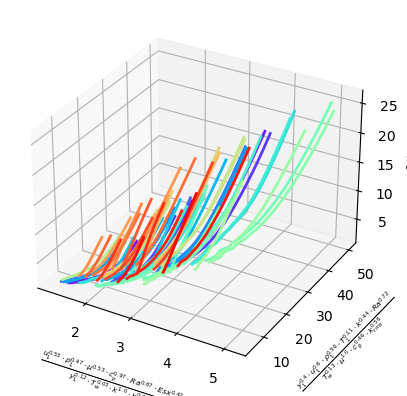

<Figure size 640x480 with 0 Axes>

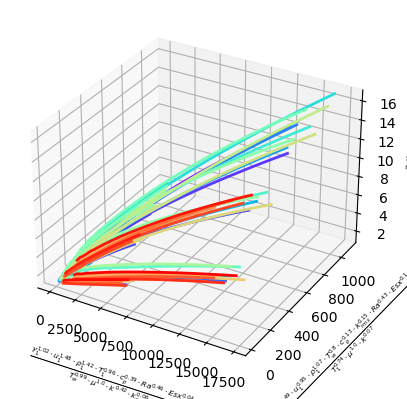

<Figure size 640x480 with 0 Axes>

In [8]:
 # Example data for input, input_tauw, output_tauw, input_qw, and output_qw
colors = plt.cm.rainbow(np.linspace(0, 1, len(ids)))

# Function to plot data
def plot_data(input_data, output_data, labels, filename, zlabel):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, id in enumerate(ids):
        id_mask = (index == id)
        ax.plot(input_data[id_mask, 0], input_data[id_mask, 1], output_data[id_mask], color=colors[i], linewidth=2)
    ax.set_xlabel(labels[0], fontsize=8, labelpad=10)
    ax.set_ylabel(labels[1], fontsize=8, labelpad=10)
    ax.set_zlabel(zlabel, fontsize=8)
    plt.grid(True)
    plt.savefig(filename,dpi=300)
    plt.show()
    plt.subplots_adjust(left=0.6, right=0.9, top=0.9, bottom=0.6)


# Plotting tauw
plot_data(input_tauw, output_tauw, tauw_lab, 'figures/tauw_pdf.png', r'$\frac{\tau_w y_1  } {\mu_1 u_1}$')

# Plotting qw
plot_data(input_qw, output_qw, qw_lab, 'figures/qw_pdf.png', r'$\frac{q_w y_1}{(T_1 -T_w) k}$')


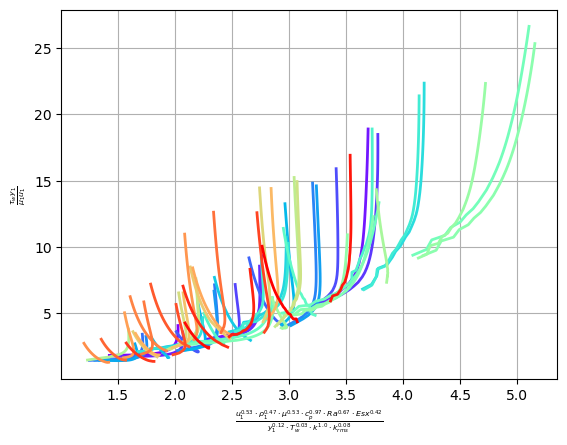

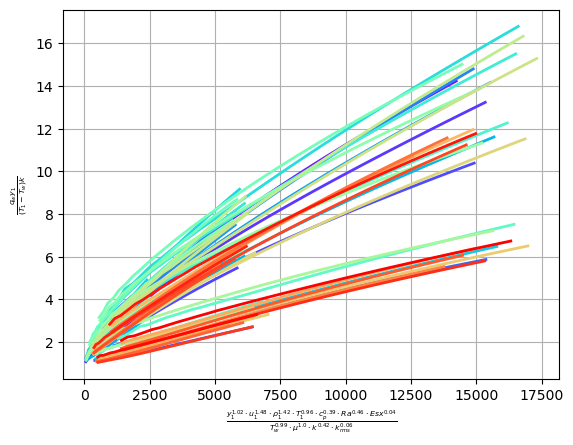

In [9]:
# Function to plot data
colors = plt.cm.rainbow(np.linspace(0, 1, len(ids)))

def plot_data(input_data, output_data, labels, filename, ylabel):
    fig, ax = plt.subplots()
    for i, id in enumerate(ids):
        id_mask = (index == id)
        ax.plot(input_data[id_mask, 0], output_data[id_mask], color=colors[i], linewidth=2)
    ax.set_xlabel(labels[0], fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    plt.grid(True)
    plt.savefig(filename, dpi=300)
    plt.show()

# Plotting tauw
plot_data(input_tauw, output_tauw, tauw_lab, 'figures/tauw_pdf.png', r'$\frac{\tau_w y_1  } {\mu_1 u_1}$')

# Plotting qw
plot_data(input_qw, output_qw, qw_lab, 'figures/qw_pdf.png', r'$\frac{q_w y_1}{(T_1 -T_w) k}$')